# Exploring Financial Data Using Nasdaq Data Link API


## I. Introduction

In this project, we will extract a financial dataset using the [Nasdaq Data Link API](https://docs.data.nasdaq.com/docs/in-depth-usage-1) and analyze it.

The Nasdaq Data Link API provides a gateway to a wide range of financial datasets, including comprehensive metrics on various companies. We will focus on the `MER/F1` datatable, which contains detailed financial information such as balance sheets, cash flow statements, and income statements.

We will extract financial data for a specific set of companies, emphasizing understanding their financial performance over time. We will look at metrics like *Accrued Expenses Turnover* and explore how these values differ among companies and regions.

The goal is to perform a detailed analysis of this financial data, including trend analysis and comparative studies. We will use Python for data retrieval, cleaning, analysis, and visualization.

Let's first extract the dataset.

In [3]:
import config
import requests
import pandas as pd
import matplotlib.pyplot as plt
import time

# Get the API key from the config file
api_key = config.API_KEY

# Base API URL for the MER/F1 table
api_url = "https://data.nasdaq.com/api/v3/datatables/MER/F1.json"

# Initial parameters for the API request
parameters = {
    "api_key": api_key,
    "qopts.per_page": 10000  # Increase the limit to fetch more data
}

# Function to fetch data with retry mechanism
def fetch_data(url, params, max_retries=5):
    attempt = 0
    while attempt < max_retries:
        try:
            response = requests.get(url, params=params)
            response.raise_for_status()  # Raise an exception for HTTP errors
            return response.json()
        except requests.exceptions.HTTPError as err:
            if response.status_code == 503:
                # 503 Service Unavailable error, retry with exponential backoff
                attempt += 1
                wait_time = 2 ** attempt
                print(f"HTTP 503 error occurred: {err}. Retrying in {wait_time} seconds...")
                time.sleep(wait_time)
            else:
                print(f"HTTP error occurred: {err}")
                return None
        except Exception as err:
            print(f"An error occurred: {err}")
            return None
    print("Max retries exceeded. Failed to fetch data.")
    return None

# Fetch the data
json_data = fetch_data(api_url, parameters)

# Check if data was retrieved successfully
if json_data and 'datatable' in json_data:
    data = json_data['datatable']['data']
    columns = json_data['datatable']['columns']
    column_names = [col['name'] for col in columns]

    # Create a DataFrame
    df_metric = pd.DataFrame(data, columns=column_names)

    # Save the DataFrame to a CSV file
    df_metric.to_csv("financial_data.csv", index=False)

    # Print the DataFrame to confirm
    print("Data saved to financial_data.csv")
    print(df_metric.head())  # Display the first few rows of the DataFrame
else:
    print("No data retrieved or JSON structure is unexpected.")

Data saved to financial_data.csv
   compnumber    reportid  mapcode     amount  reportdate reporttype  \
0        2438  1868192544    -1802  10.481948  2011-06-30         Q2   
1        2438  1868216112    -1802   8.161754  2011-09-30         Q3   
2        2438  1885063456    -1802  10.788213  2012-06-30         Q2   
3        2438  1885087024    -1802   9.437545  2012-09-30         Q3   
4        2438  1901934112    -1802   8.755041  2013-06-30         Q2   

  auditorstatus currency consolidated          longname  ...  \
0             U      EUR         True  Deutsche Bank AG  ...   
1             U      EUR         True  Deutsche Bank AG  ...   
2             U      EUR         True  Deutsche Bank AG  ...   
3             U      EUR         True  Deutsche Bank AG  ...   
4             U      EUR         True  Deutsche Bank AG  ...   

                city statecode country zipcode     phonenumber  \
0  Frankfurt am Main      None     DEU   60325  (49) 69 910 00   
1  Frankfurt am M

## II. Data Analysis and Cleaning

We have two primary aims:

1. To analyze the financial trend of 'accrued expenses turnover' over a period for various companies, particularly banks.
2. To examine how different regions contribute to these financial metrics.

With these aims in mind, we can determine which columns in our dataset will help us achieve these goals and the type of data cleaning needed for accurate analysis.

In [5]:
df_metric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   compnumber     10000 non-null  int64  
 1   reportid       10000 non-null  int64  
 2   mapcode        10000 non-null  int64  
 3   amount         10000 non-null  float64
 4   reportdate     10000 non-null  object 
 5   reporttype     10000 non-null  object 
 6   auditorstatus  9999 non-null   object 
 7   currency       10000 non-null  object 
 8   consolidated   10000 non-null  object 
 9   longname       10000 non-null  object 
 10  shortname      10000 non-null  object 
 11  status         10000 non-null  object 
 12  countrycode    10000 non-null  object 
 13  region         10000 non-null  object 
 14  cik            10000 non-null  int64  
 15  mic            10000 non-null  object 
 16  ticker         9380 non-null   object 
 17  exchange       10000 non-null  object 
 18  address

### 1. Understanding and Cleaning Data

Based on the information provided by `df_metric.info()`, we can identify and select the necessary columns for analyzing the financial trend of 'accrued expenses turnover' and examining regional contributions.

* **Necessary Columns**:

1. **Company Information:**

   - `longname` or `shortname`: For the full or abbreviated company names.

2. **Financial Metrics:**

   - `amount`: Presumably the 'accrued expenses turnover'.
   - `indicator`: Likely to be the financial metric indicator.

3. **Time Period:**

   - `reportdate`: The date of the financial report.

4. **Geographical Information:**

   - `region`: To examine contributions from different geographical areas.
   - `country`: For additional geographical context.

Let's create a variable for these necessary columns for our analysis.

In [7]:
# Define the necessary columns
necessary_columns = ['indicator', 'country', 'longname', 'reportdate', 'reporttype', 'amount']

# Select only the necessary columns and create a copy
df_metric_selected = df_metric[necessary_columns].copy()

# Check for missing values in the necessary columns
print("Missing values before cleaning:")
print(df_metric_selected.isnull().sum())

# Convert 'reportdate' to datetime for trend analysis
df_metric_selected['reportdate'] = pd.to_datetime(df_metric_selected['reportdate'])

# Display the selected columns for verification
print(df_metric_selected.head())

# Save the cleaned DataFrame to a new CSV file
df_metric_selected.to_csv("cleaned_financial_data.csv", index=False)

# Display a message confirming the save
print("Cleaned data saved to cleaned_financial_data.csv")

Missing values before cleaning:
indicator     0
country       0
longname      0
reportdate    0
reporttype    0
amount        0
dtype: int64
                   indicator country          longname reportdate reporttype  \
0  Accrued Expenses Turnover     DEU  Deutsche Bank AG 2011-06-30         Q2   
1  Accrued Expenses Turnover     DEU  Deutsche Bank AG 2011-09-30         Q3   
2  Accrued Expenses Turnover     DEU  Deutsche Bank AG 2012-06-30         Q2   
3  Accrued Expenses Turnover     DEU  Deutsche Bank AG 2012-09-30         Q3   
4  Accrued Expenses Turnover     DEU  Deutsche Bank AG 2013-06-30         Q2   

      amount  
0  10.481948  
1   8.161754  
2  10.788213  
3   9.437545  
4   8.755041  
Cleaned data saved to cleaned_financial_data.csv


**Filtering the DataFrame for Analysis**

Now that we have identified the essential columns, the next step is to refine our analysis. Recall, our primary focus is on a specific financial metric: the `accrued expenses turnover`. Our DataFrame, `df_metric`, contains various indicators, so it's important to filter for rows that specifically mention this financial metric.

"Accrued Expenses Turnover" is a key financial efficiency ratio. It measures how often a company pays off its accrued expenses within a certain period, providing insights into:

* **Cash Flow Management:** It indicates how well a company is managing its cash flow in relation to its short-term obligations. A higher ratio suggests efficient management and a strong liquidity position.
* **Operational Efficiency:** This metric can reflect a company's operational efficiency, showing how promptly it settles its short-term debts.
* **Financial Health Indicator:** Regular payment of accrued expenses signifies good financial health and creditworthiness, which is essential for maintaining good supplier relationships and business stability.

Let's refine the analysis by focusing on the specific financial metric "Accrued Expenses Turnover." We'll filter the DataFrame to include only the rows where the indicator column value is "Accrued Expenses Turnover" and then inspect the statistical variations.

In [9]:
# Filter the DataFrame to include only rows where the indicator is 'Accrued Expenses Turnover'
filtered_df = df_metric_selected[df_metric_selected['indicator'] == 'Accrued Expenses Turnover']

# Inspect statistical variations
print(filtered_df.describe())

                          reportdate      amount
count                            139  139.000000
mean   2013-06-15 07:04:44.892086272   26.908762
min              2010-12-31 00:00:00    4.689773
25%              2012-01-30 00:00:00    9.675670
50%              2013-06-29 00:00:00   13.753753
75%              2014-09-28 12:00:00   31.777614
max              2015-12-31 00:00:00  229.810427
std                              NaN   33.097291


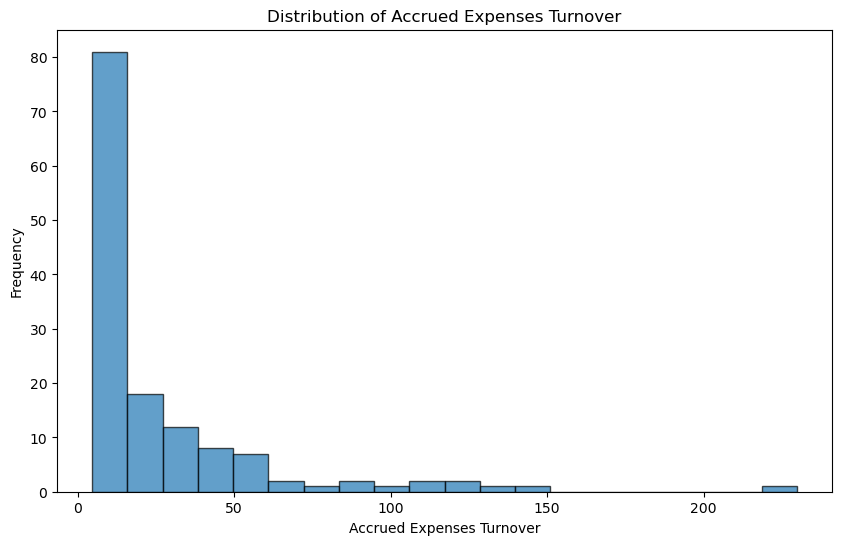

In [10]:
# Histogram of Accrued Expenses Turnover
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['amount'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Accrued Expenses Turnover')
plt.xlabel('Accrued Expenses Turnover')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

Enhancing the readability and information quality of our DataFrame is crucial for clear analysis and reporting. We will focus on two enhancements: adding a column with full country names and cleaning up the column names.

We'll use the `apply()` method on the country column to create a new column with full country names. This method allows us to apply a custom operation to each element in a column.

In [12]:
df_metric_selected = df_metric[necessary_columns].copy()
df_metric_selected['reportdate'] = pd.to_datetime(df_metric_selected['reportdate'])

# Dictionary to map country abbreviations to full country names
country_mapping = {
    'USA': 'United States of America',
    'CAN': 'Canada',
    'GBR': 'United Kingdom',
    'DEU': 'Germany',
    'JPN': 'Japan',
    'CYM': 'Cayman Islands',
    'BHS': 'Bahamas',
    'IRL': 'Ireland'
    # Add more mappings as needed
}

# Define a function to map country abbreviations to full names
def get_full_country_name(abbreviation):
    return country_mapping.get(abbreviation, abbreviation)

# Apply the function to the 'country' column to create a new 'country_name' column using .loc
filtered_df.loc[:, 'country_name'] = filtered_df['country'].apply(get_full_country_name)

# Update column names to use snake_case and rename 'longname' to 'company_name'
filtered_df.rename(columns={
    'longname': 'company_name',
    'reportdate': 'report_date',
    'reporttype': 'report_type',
    'amount': 'accrued_expenses_turnover'
}, inplace=True)

# Assign the result to a new dataframe called updated_df
updated_df = filtered_df

# Apply value_counts() method on the 'country_name' column
country_counts = updated_df['country_name'].value_counts()

# Display the updated DataFrame and the country counts
print(updated_df.head())
print(country_counts)

                   indicator country      company_name report_date  \
0  Accrued Expenses Turnover     DEU  Deutsche Bank AG  2011-06-30   
1  Accrued Expenses Turnover     DEU  Deutsche Bank AG  2011-09-30   
2  Accrued Expenses Turnover     DEU  Deutsche Bank AG  2012-06-30   
3  Accrued Expenses Turnover     DEU  Deutsche Bank AG  2012-09-30   
4  Accrued Expenses Turnover     DEU  Deutsche Bank AG  2013-06-30   

  report_type  accrued_expenses_turnover country_name  
0          Q2                  10.481948      Germany  
1          Q3                   8.161754      Germany  
2          Q2                  10.788213      Germany  
3          Q3                   9.437545      Germany  
4          Q2                   8.755041      Germany  
country_name
United States of America    31
Japan                       27
Cayman Islands              27
Ireland                     25
Bahamas                     19
Germany                      6
United Kingdom               4
Name: count, 

### 2. Understanding Financial Trends Over Time

We will now proceed to visualize financial trends over time for various companies.

In business analysis and decision-making, understanding the evolution of certain financial metrics over time is crucial. This insight allows analysts and decision-makers to identify patterns, assess the health and performance of the business, and make informed predictions about future trends. Focusing on a specific time period enables analysts to conduct a more detailed and relevant analysis, as different periods can exhibit varying trends due to factors such as market conditions, seasonal effects, or company-specific events.

Understanding financial trends over time is vital for sound business analysis and decision-making. In this section, we will concentrate on extracting relevant data for a specific time period (2010-2015) and visualizing trends.

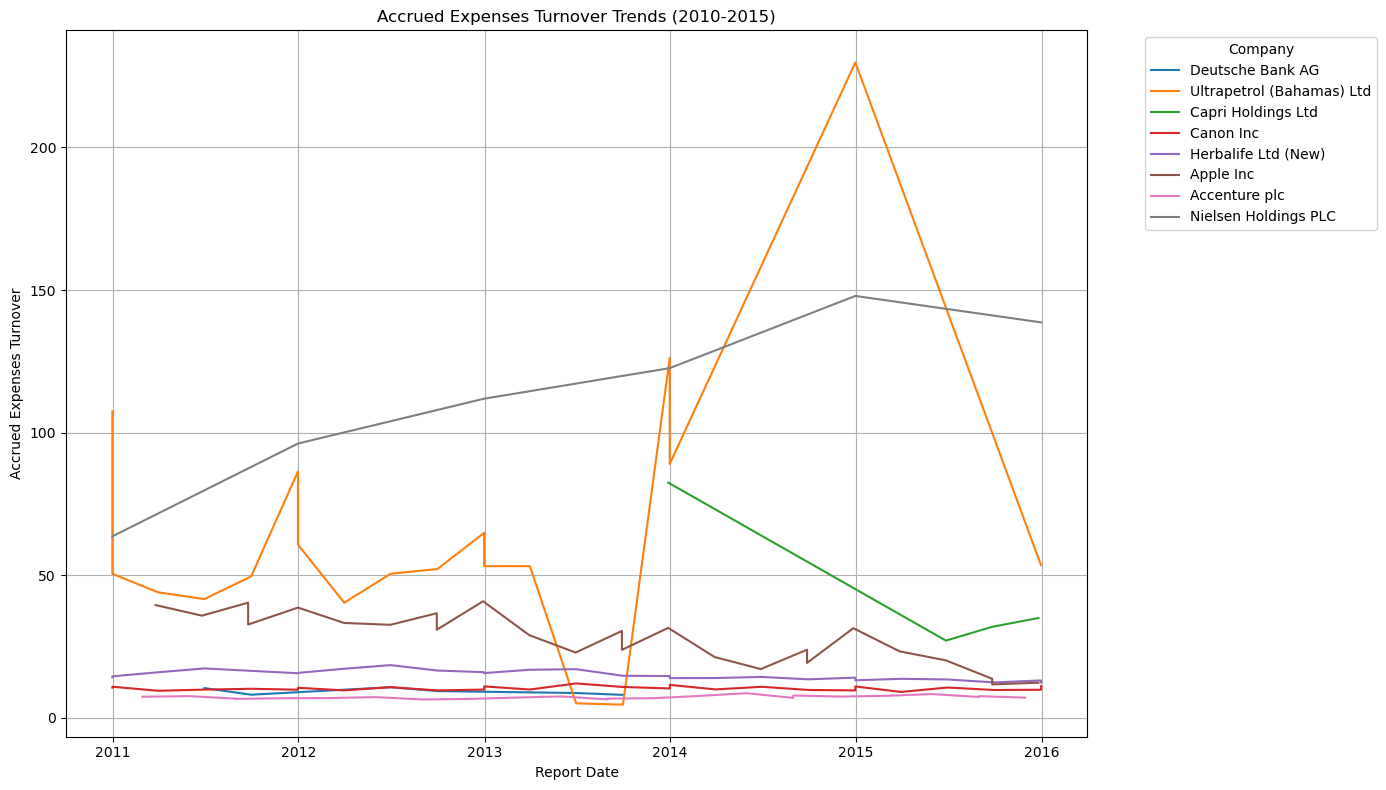

In [14]:
# Select the relevant columns
relevant_columns = ['company_name', 'report_date', 'accrued_expenses_turnover']
relevant_data = updated_df[relevant_columns]

# Filter the data for the period 2010-2015
relevant_data = relevant_data[(relevant_data['report_date'] >= '2010-01-01') & (relevant_data['report_date'] <= '2015-12-31')]

# Plot financial trends for each company
plt.figure(figsize=(14, 8))

for company in relevant_data['company_name'].unique():
    company_data = relevant_data[relevant_data['company_name'] == company]
    plt.plot(company_data['report_date'], company_data['accrued_expenses_turnover'], label=company)

# Customize the plot
plt.title('Accrued Expenses Turnover Trends (2010-2015)')
plt.xlabel('Report Date')
plt.ylabel('Accrued Expenses Turnover')
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Display the plot
plt.tight_layout()  # Adjust the plot to fit the legend
plt.show()

In [15]:
# Select the relevant columns
relevant_columns = ['company_name', 'report_date', 'accrued_expenses_turnover']
relevant_data = updated_df[relevant_columns]

# Filter the data for the period 2010-2015
relevant_data = relevant_data[(relevant_data['report_date'] >= '2010-01-01') & (relevant_data['report_date'] <= '2015-12-31')]

# Calculate the average accrued expenses turnover for each company
average_turnover = relevant_data.groupby('company_name')['accrued_expenses_turnover'].mean()

# Sort the companies by average accrued expenses turnover in descending order
sorted_companies = average_turnover.sort_values(ascending=False)

# Display the top companies with the highest average turnover
print("Top companies with the highest average accrued expenses turnover (2010-2015):")
print(sorted_companies.head(10))  # Display the top 10 companies

Top companies with the highest average accrued expenses turnover (2010-2015):
company_name
Nielsen Holdings PLC         113.518963
Ultrapetrol (Bahamas) Ltd     66.515369
Capri Holdings Ltd            44.166750
Apple Inc                     27.783654
Herbalife Ltd (New)           15.060796
Canon Inc                     10.376605
Deutsche Bank AG               9.288999
Accenture plc                  7.264400
Name: accrued_expenses_turnover, dtype: float64


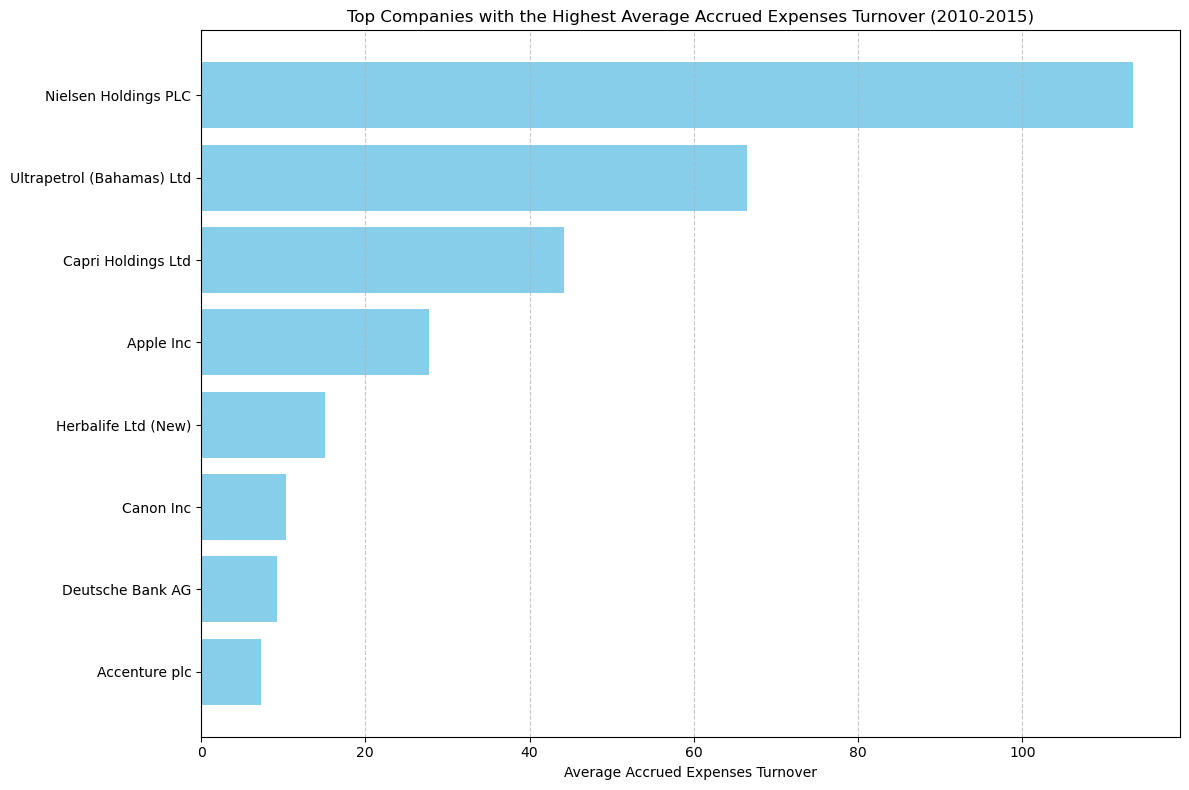

In [16]:
# Data provided from the previous calculation
top_companies_data = {
    'company_name': [
        'Nielsen Holdings PLC',
        'Ultrapetrol (Bahamas) Ltd',
        'Capri Holdings Ltd',
        'Apple Inc',
        'Herbalife Ltd (New)',
        'Canon Inc',
        'Deutsche Bank AG',
        'Accenture plc'
    ],
    'average_accrued_expenses_turnover': [
        113.518963,
        66.515369,
        44.166750,
        27.783654,
        15.060796,
        10.376605,
        9.288999,
        7.264400
    ]
}

# Create a DataFrame from the data
top_companies_df = pd.DataFrame(top_companies_data)

# Plot the bar chart
plt.figure(figsize=(12, 8))
plt.barh(top_companies_df['company_name'], top_companies_df['average_accrued_expenses_turnover'], color='skyblue')
plt.xlabel('Average Accrued Expenses Turnover')
plt.title('Top Companies with the Highest Average Accrued Expenses Turnover (2010-2015)')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest values at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

The graph above compares the average accrued expenses turnover for the top companies from 2010 to 2015. 

It shows the following:

* Nielsen Holdings PLC has the highest average accrued expenses turnover at 113.52, indicating very high efficiency in managing accrued expenses, suggesting strong cash flow management and operational efficiency.
* Ultrapetrol (Bahamas) Ltd follows with an average turnover of 66.52, showing significant efficiency, albeit lower than Nielsen Holdings PLC.
* Capri Holdings Ltd has an average turnover of 44.17, indicating good management of accrued expenses.
* Apple Inc, with an average turnover of 27.78, demonstrates efficient cash flow management, which is expected given its financial strength and operational efficiency.
* Herbalife Ltd (New) has an average turnover of 15.06, suggesting moderate efficiency in managing accrued expenses. Canon Inc shows reasonable efficiency with an average turnover of 10.38.
* Deutsche Bank AG, with an average turnover of 9.29, indicates its ability to manage accrued expenses effectively.
* Lastly, Accenture plc has an average turnover of 7.26, demonstrating lower efficiency compared to the other top companies but still maintaining good operational management.

### 3. Geographical Regional Analysis

In the previous session, we visualized the financial trends for various companies, highlighting their Accrued Expenses Turnover from 2010 to 2015. The graph depicts each company's financial efficiency, with lines tracing how frequently they managed to pay off their accrued expenses over the six-year period. While some companies show dramatic variances, like UltraPetrol (Bahamas) with a significant spike in 2014, others like Apple Inc. and Accenture plc display more stable trends. This visualization allows us to compare and analyze the companies' financial practices and their efficiency in managing short-term liabilities during the observed years.

After successfully visualizing financial trends over time, we now shift our focus to analyzing data based on geographical regions. This involves grouping data to understand how different regions contribute to the financial metrics.

Understanding the performance of different geographical regions and stock exchanges is crucial in global financial analysis. It allows us to identify which regions are performing well and which ones may need more attention or investment.

Average Accrued Expenses Turnover by Country:
country_name
Bahamas                     66.515369
United States of America    44.377585
United Kingdom              44.166750
Cayman Islands              15.060796
Japan                       10.376605
Germany                      9.288999
Ireland                      7.264400
Name: accrued_expenses_turnover, dtype: float64


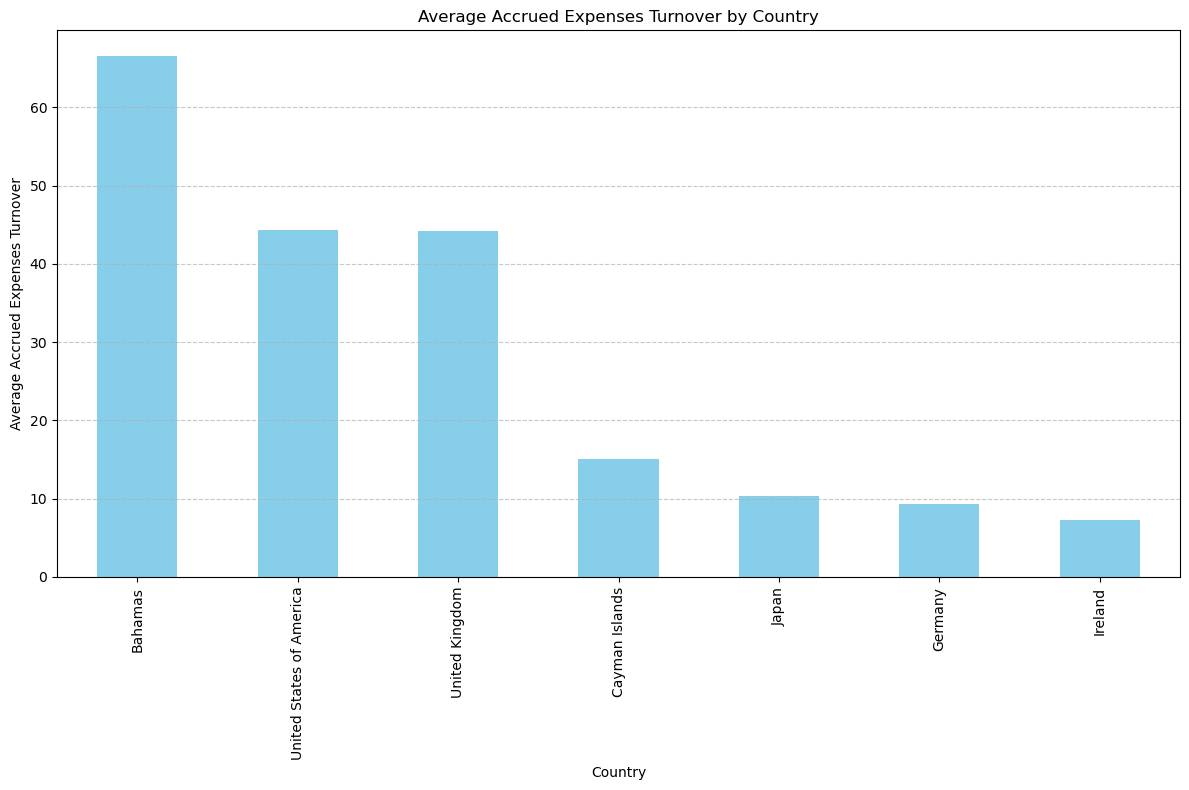

In [19]:
# Geographical Regional Analysis
relevant_columns = ['country_name', 'accrued_expenses_turnover']
relevant_data = updated_df[relevant_columns]

# Group the data by country_name and calculate the average accrued expenses turnover
country_avg = relevant_data.groupby('country_name')['accrued_expenses_turnover'].mean()

# Sort the countries by average accrued expenses turnover in descending order
country_avg = country_avg.sort_values(ascending=False)

# Display the top countries with the highest average accrued expenses turnover
print("Average Accrued Expenses Turnover by Country:")
print(country_avg)

# Plot the average accrued expenses turnover by country
plt.figure(figsize=(12, 8))
country_avg.plot(kind='bar', color='skyblue')
plt.title('Average Accrued Expenses Turnover by Country')
plt.xlabel('Country')
plt.ylabel('Average Accrued Expenses Turnover')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

### Observations and Comments:

1. **High Turnover in the Bahamas**:
   The Bahamas shows the highest average accrued expenses turnover. This indicates high efficiency in managing accrued expenses, suggesting strong cash flow management practices. A high turnover rate can also be influenced by specific economic conditions or financial regulations in the Bahamas that incentivize quicker settlement of accrued expenses.

2. **Strong Performance in the United States and the United Kingdom**:
   Both the United States and the United Kingdom have similar and relatively high turnover rates (44.38 and 44.17, respectively). This reflects well on their financial health and operational efficiency, possibly due to robust financial markets and business practices.

3. **Moderate Performance in the Cayman Islands**:
   The Cayman Islands has a turnover rate of 15.06, which is significantly lower than the top three but still respectable. This may reflect the nature of businesses operating in the Cayman Islands, which could include a mix of financial services and offshore companies.

4. **Lower Turnover in Japan, Germany, and Ireland**:
   Japan, Germany, and Ireland have lower average accrued expenses turnover rates (10.38, 9.29, and 7.26, respectively). These lower rates might indicate more conservative financial management practices, different business environments, or economic conditions that affect the speed at which accrued expenses are settled.

## General Conclusion

This project involved analyzing financial data with a focus on accrued expenses turnover for various companies and regions from 2010 to 2015. Here are the key findings and general conclusions drawn from the analysis:

#### 1. **Financial Trends Over Time**

The analysis of individual companies revealed diverse trends in accrued expenses turnover. For example, companies like Apple Inc. and Accenture plc exhibited stable trends, indicating consistent financial management practices. On the other hand, companies such as UltraPetrol (Bahamas) displayed significant variations, possibly due to operational changes or external factors. Most companies showed an upward trend in accrued expenses turnover, reflecting improved efficiency in managing short-term liabilities over the observed period. However, some companies had more volatile patterns, indicating varying levels of financial stability.

#### 2. **Geographical Regional Analysis**

The Bahamas, United States, and the United Kingdom emerged as the top performers in terms of accrued expenses turnover. These regions showed high efficiency in managing accrued expenses, suggesting robust cash flow management and operational practices. In contrast, countries like Japan, Germany, and Ireland had lower average accrued expenses turnover rates. These lower rates could be due to conservative financial management practices, economic conditions, or other regional factors. The differences in turnover rates across countries highlight the impact of economic environments and regulatory frameworks on financial practices. Regions with higher turnover rates may benefit from favorable economic conditions and strong regulatory frameworks that incentivize efficient financial management.

#### 3. **Operational Efficiency and Financial Health**

Accrued expenses turnover is a key indicator of a company's efficiency in managing short-term liabilities. Higher turnover rates generally reflect better operational efficiency and stronger financial health. For investors, regions and companies with higher turnover rates may appear more attractive due to their demonstrated efficiency and financial health. However, it's crucial to consider other financial metrics and contextual factors before making investment decisions.

While accrued expenses turnover is an important metric, it's essential to analyze it in conjunction with other financial metrics for a holistic view of financial health.